In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
from matplotlib.lines import Line2D
import csv
import glob
import networkx as nx

from ETN import count_ETN, get_dict, obtain_ETN_subgraph, get_ETNS
from ETNgen import generate_seed_graph,generate_next_layer
from topological_metrics import get_weighted_graph
from utils import *

%load_ext autoreload
%autoreload 2

# Find ego-subgraphs in original network

Characteristics of the datasets found in Detect_temporal_states_and_communities.ipynb

In [2]:
#dataset = "pr_school";gap = 300;state_L_gap = 1200;state_e_gap = 1200;nb_states_L = 3;nb_states_e = 8
#dataset = "h_school11";gap = 1200;state_L_gap = 1200;state_e_gap = 1200;nb_states_L = 3;nb_states_e = 7
#dataset = "h_school13";gap = 1200;state_L_gap = 1200;state_e_gap = 1200;nb_states_L = 4;nb_states_e = 29
#dataset = "InVS15";gap = 3600;state_L_gap = 3600;state_e_gap = 3600;nb_states_L = 3;nb_states_e = 12
dataset = "hypertext";gap = 1200;state_L_gap = 1200;state_e_gap = 1200;nb_states_L = 3;nb_states_e = 20

Load original network as an array of static graphs

In [3]:
data_in = load_data("Datasets/"+dataset+".dat")
orig_graph = build_graphs(data_in,gap=gap)
len(orig_graph)

177

In [4]:
d = 2

Split the graph according to states

In [5]:
states_e_directory = 'Datasets/etn_states_%s_gap_%d_%dstates/'%(dataset,state_e_gap,nb_states_e)
states_e = np.load(states_e_directory+'states.npy')
if len(states_e) < len(orig_graph)*gap/state_e_gap:
    states_e = list(states_e) + [states_e[-1]]

Assign the state $s_e$ to each snapshot $t$

In [6]:
r = int(round(state_e_gap/gap))
state_e_this_t = np.full(len(orig_graph),0)
for t in range(len(orig_graph) - d):
    st = int(t/r)
    state_e_this_t[t] = int(states_e[st])

Assign the snapshot index $t$ to each state $s_e$

In [7]:
state_times = {}
for s in np.unique(state_e_this_t):
    state_times[s] = [i for i,x in enumerate(state_e_this_t) if x==s]

Count ego-subgraphs and store them in dictionaries (one for each state)

In [8]:
dizs = []
for s in np.unique(states_e):
    ETNS_dict = dict()
    for t in state_times[s]:
        graphs = orig_graph[t:t+d+1] # snapshot t and the next d
        for v in graphs[0].nodes():
            etn = obtain_ETN_subgraph(graphs,v)
            if not etn == None:
                etns,_ = get_ETNS(etn)
                if etns in ETNS_dict.keys():
                    ETNS_dict[etns] = ETNS_dict[etns] + 1
                else:
                    ETNS_dict[etns] = 1
    diz = get_dict(ETNS_dict,d)
    dizs.append(diz)

# Generate the surrogate networks

### Generation features

Choose the length of the temporal graph

In [9]:
nb_graphs = len(orig_graph)

Choose the type of surrogate: 'E', 'ES', or 'EST'

In [10]:
net = 'EST' #'ES', 'E'

In [11]:
if net == 'E':
    classes_ = 0
    chi_ = 0
    p_cl_ = 0    
        
elif net == 'ES' or net == 'EST':
    states_L_directory = 'Datasets/Lapl_states_%s_gap_%d_%dstates/'%(dataset,state_L_gap,nb_states_L)
    states_L = np.load(states_L_directory+'states.npy')
    #Assign the state s_L to each snapshot t
    r = int(round(state_L_gap/gap))
    state_L_this_t = np.full(len(orig_graph),0)
    for t in range(len(orig_graph)):
        st = int(t/r)
        state_L_this_t[t] = int(states_L[st])
    # Upload classes
    classes_ = []
    for s in range(len(glob.glob1(states_L_directory,"classes*_orig_gap_%d.npy"%gap))):
        globals()['classes%d'%s] = np.load(states_L_directory+'classes%d_orig_gap_%d.npy'%(s,gap),allow_pickle=True).item()
        classes_.append(globals()['classes%d'%(s)])
    chi_ = np.load(states_L_directory+'chi_orig_gap_%d.npy'%gap,allow_pickle=True)
    

Choose if to consider absent nodes or not. Considering them means uploading the file (generated by Find_absent_nodes.ipynb) of absent nodes, here organized per days, and exclude absent nodes when generating the corresponding days. 

This is not mandatory, the network can be generated also making all the nodes participate to the network every day. In case, choose abs_nodes_flag = False.

In [12]:
abs_nodes_flag = True

In [13]:
if abs_nodes_flag:
    abs_nodes = load_list_of_lists_csv_int('Datasets/absent_nodes_days_%s.csv'%dataset)
    nights_start = np.load('Datasets/night_start_times_%s.npy'%dataset,allow_pickle=True)
    nb_days = len(abs_nodes)
else:
    abs_nodes = [[]]

### Generate 

In [14]:
def update_name(dataset,gap,net):
    
    new_temporal_graph_name = dataset +'_%s_gap_%d_%d_states_e'%(net,gap,nb_states_e)       
    if net != 'E':
        new_temporal_graph_name = new_temporal_graph_name + '_%d_states_L'%nb_states_L
    return new_temporal_graph_name

In [15]:
def generate_and_store_E(orig_graph,d,nb_graphs,dizs,gap,dataset):
    
    # INITIALIZE --------------------------------------------------------------------------------- 
    day = 0
    Params = {'clust_modul': False,
              'memory': False,
              'absent_nodes': abs_nodes[0]}
    edge_list = []
    
    # SEED GRAPH---------------------------------------------------------------------------------
    g0 = nx.configuration_model(list(dict(orig_graph[0].degree()).values())) # first layer: configuration model
    graph_seed = generate_seed_graph(orig_graph,g0,d,Params)
    # store seed:
    for t in range(d):
        edges = list(graph_seed[t].edges())
        for a,b in edges:
            edge_list.append([(t)*gap,a,b])
    nodes = list(graph_seed[0].nodes())
    temp_graph = graph_seed
            
    # GENERATE--------------------------------------------------------------------------------- 
    for time in tqdm(range(len(graph_seed),nb_graphs)):
        diz = dizs[state_e_this_t[time-d]] 
        graphs_in = temp_graph[time-d:time]
        g_new = generate_next_layer(nodes,graphs_in,diz,d,Params)
        temp_graph.append(g_new)
        
        edges = list(g_new.edges())
        for a,b in edges:
            edge_list.append([time*gap,a,b])
            
        # absent nodes
        if abs_nodes_flag:
            if day < nb_days - 1:
                if time == nights_start[day]:
                    day += 1
                    Params['absent_nodes'] = abs_nodes[day]
    edge_list.append([time*gap,0,0])
    
    # SAVE--------------------------------------------------------------------------------- 
    new_temporal_graph_name = update_name(dataset,gap,net)
    directory = "Generated_graphs/d%d/"%d+new_temporal_graph_name
    print('directory',directory)
    if not os.path.exists(directory):
        os.makedirs(directory)
    df_edge_list = pd.DataFrame(edge_list,columns=["time","node_A","node_B"])
    df_edge_list.to_csv(directory+"/%d.dat"%run,sep=" ",index=False,header=False)
    
    return temp_graph,edge_list

In [16]:
def generate_and_store_ES(orig_graph,d,nb_graphs,dizs,gap,dataset,classes_,chi_,state_L_this_t):
        
    # INITIALIZE --------------------------------------------------------------------------------- 
    day = 0
    chi = chi_[state_L_this_t[0]]
    classes = classes_[state_L_this_t[0]]
    Params = {'clust_modul': True,
              'classes': classes,
              'chi': chi,
              #'c': c # put c<1 if want to reproduce a reduced clustering
              'memory': False,
              'state': state_L_this_t[0],
              'absent_nodes': abs_nodes[0]}
    edge_list = []
    
    # SEED GRAPH---------------------------------------------------------------------------------
    g0 = nx.configuration_model(list(dict(orig_graph[0].degree()).values())) # first layer: configuration model
    graph_seed = generate_seed_graph(orig_graph,g0,d,Params)
    # save seed:
    for t in range(d):
        edges = list(graph_seed[t].edges())
        for a,b in edges:
            edge_list.append([(t)*gap,a,b])
    nodes = list(graph_seed[0].nodes())
    temp_graph = graph_seed   
    
    # GENERATE---------------------------------------------------------------------------------     
    for time in tqdm(range(len(graph_seed),nb_graphs)):
        diz = dizs[state_e_this_t[time - d]] 
        Params['chi'] = chi_[state_L_this_t[time]]
        Params['classes'] = classes_[state_L_this_t[time]]
        Params['state'] = state_L_this_t[time]
            
        graphs_in = temp_graph[time - d:time]
        g_new = generate_next_layer(nodes,graphs_in,diz,d,Params)
        
        temp_graph.append(g_new)
        
        edges = list(g_new.edges())
        for a,b in edges:
            edge_list.append([time*gap,a,b])
            
        # absent nodes
        if abs_nodes_flag:
            if day < nb_days - 1:
                if time == nights_start[day]:
                    day += 1
                    Params['absent_nodes'] = abs_nodes[day]
    edge_list.append([time*gap,0,0])
    
    # SAVE--------------------------------------------------------------------------------- 
    new_temporal_graph_name = update_name(dataset,gap,net)
    directory = "Generated_graphs/d%d/"%d+new_temporal_graph_name
    print('directory',directory)
    if not os.path.exists(directory):
        os.makedirs(directory)
    df_edge_list = pd.DataFrame(edge_list,columns=["time","node_A","node_B"])
    df_edge_list.to_csv(directory+"/%d.dat"%run,sep=" ",index=False,header=False)
    
    return temp_graph,edge_list

In [17]:
def generate_and_store_EST(orig_graph,d,nb_graphs,dizs,gap,dataset,classes_,chi_,state_L_this_t):
        
    # INITIALIZE ---------------------------------------------------------------------------------
    #################
    day = 0
    #################
    chi = chi_[state_L_this_t[0]]
    classes = classes_[state_L_this_t[0]]
    
    G0 = nx.Graph()
    G0.add_nodes_from(orig_graph[0].nodes()) # empty graph (only nodes without edges)
    Params = {'clust_modul': True,
              'classes': classes,
              'chi': chi,
              #'c': c # put c<1 if want to reproduce a reduced clustering
              'memory': True,
              'state': state_L_this_t[0],
              'absent_nodes':abs_nodes[0]} 
    edge_list = []
    
    # SEED GRAPH---------------------------------------------------------------------------------
    g0 = nx.configuration_model(list(dict(orig_graph[0].degree()).values())) # first layer: configuration model
    graph_seed = generate_seed_graph(orig_graph,g0,d,Params)
    nodes = list(graph_seed[0].nodes())
    temp_graph = graph_seed
    
    # FIRST 24H (NOT TO BE SAVED)--------------------------------------------------------------------
    relax_time = 24 #hours
    for time in tqdm(range(len(graph_seed),int(relax_time*3600/gap)+len(graph_seed))): 
        diz = dizs[state_e_this_t[time - d]] 
        Params['chi'] = chi_[state_L_this_t[time]]
        Params['classes'] = classes_[state_L_this_t[time]]
        Params['state'] = state_L_this_t[time]
        graphs_in = temp_graph[-d:]
        g_new = generate_next_layer(nodes,graphs_in,diz,d,Params)
        temp_graph.append(g_new)
    relaxed_seed = temp_graph[-d:]
    temp_graph2 = relaxed_seed
    # save relaxed seed:
    for t in range(d):
        edges = list(relaxed_seed[t].edges())
        for a,b in edges:
            edge_list.append([(t)*gap,a,b])  
            
    # AFTER FIRST 24H (TO BE SAVED)--------------------------------------------------------------------
    for time in tqdm(range(d,nb_graphs)): 
        diz = dizs[state_e_this_t[time - d]]  
        Params['chi'] = chi_[state_L_this_t[time]]
        Params['classes'] = classes_[state_L_this_t[time]]
        Params['state'] = state_L_this_t[time]
        graphs_in = temp_graph[-d:]
        g_new = generate_next_layer(nodes,graphs_in,diz,d,Params)
        temp_graph.append(g_new)
        temp_graph2.append(g_new)

        edges = list(g_new.edges())
        for a,b in edges:
            edge_list.append([(time)*gap,a,b])

        # absent nodes
        if abs_nodes_flag:
            if day < nb_days - 1:
                if time == nights_start[day]:
                    day += 1
                    Params['absent_nodes'] = abs_nodes[day]
          
    edge_list.append([(time)*gap,0,0])
    
    # SAVE--------------------------------------------------------------------------------- 
    new_temporal_graph_name = update_name(dataset,gap,net)
    directory = "Generated_graphs/d%d/"%d+new_temporal_graph_name
    print('directory',directory)
    if not os.path.exists(directory):
        os.makedirs(directory)
    df_edge_list = pd.DataFrame(edge_list,columns=["time","node_A","node_B"])
    df_edge_list.to_csv(directory+"/%d.dat"%run,sep=" ",index=False,header=False)
    
    return temp_graph,edge_list

Number of surrogates to generate:

In [27]:
runs = 10

In [28]:
gen_graphs = []
for run in range(runs):
    print('run',run)
    
    if net == 'E':
        tg,edge_list = generate_and_store_E(orig_graph,
                                             d,
                                             nb_graphs,
                                             dizs,
                                             gap,
                                             dataset)
    
    elif net == 'ES':
        tg,edge_list = generate_and_store_ES(orig_graph,
                                             d,
                                             nb_graphs,
                                             dizs,
                                             gap,
                                             dataset,
                                             classes_,
                                             chi_,
                                             state_L_this_t)
        
    elif net == 'EST':
        tg,edge_list = generate_and_store_EST(orig_graph,
                                             d,
                                             nb_graphs,
                                             dizs,
                                             gap,
                                             dataset,
                                             classes_,
                                             chi_,
                                             state_L_this_t)

    gen_graphs.append(tg)


run 0


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

directory Generated_graphs/d2/hypertext_EST_gap_1200_20_states_e_3_states_L


# Plot nb of interactions:

In [20]:
def get_number_of_interactions(graphs):
    nb_inter = []
    for g in graphs:
        nb_inter.append(len(g.edges()))
    return nb_inter

In [21]:
def compute_avg_std_nb_inter(all_graphs):
    nb_int = []
    for graph in all_graphs:
        
        nb_int.append(get_number_of_interactions(graph))

    mean_nb_int = np.mean(nb_int,axis=0)
    std_nb_int = np.std(nb_int,axis=0)
    return mean_nb_int,std_nb_int

In [22]:
ORIGINAL_COLOR = "#424242"
ETN_COLOR = "#F3AA20"

In [23]:
plt.rcParams.update({'font.size': 14})

In [24]:
# orig
nb_inter_orig = get_number_of_interactions(orig_graph)
days_o = np.array(range(len(nb_inter_orig)))*gap/3600/24

In [25]:
# generated
m,s = compute_avg_std_nb_inter(gen_graphs)
days_ma_g = np.array(range(len(m)))*gap/3600/24

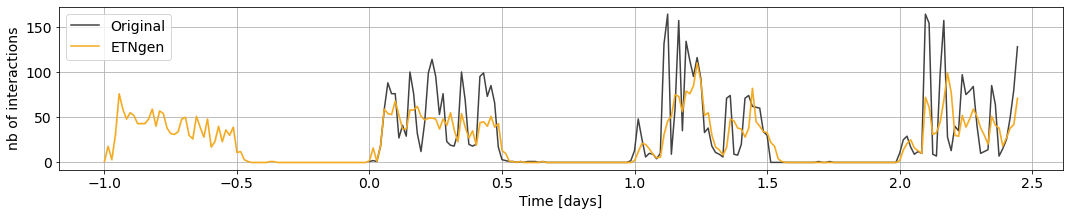

In [26]:
plt.figure(figsize=(18,3))
plt.plot(days_o,nb_inter_orig,color=ORIGINAL_COLOR,label="Original")
if net == 'E' or net == 'ES':
    plt.plot(days_ma_g,m,color=ETN_COLOR,label="ETNgen")
    plt.fill_between(days_ma_g,m+s,m-s,color=ETN_COLOR,alpha=0.3)
    
else:
    relax_time = 24 #hours
    plt.plot(days_ma_g-relax_time/24,m,color=ETN_COLOR,label="ETNgen")
    plt.fill_between(days_ma_g-relax_time/24,m+s,m-s,color=ETN_COLOR,alpha=0.3)
plt.ylabel("nb of interactions")
plt.xlabel('Time [days]')
plt.grid()
plt.legend()
plt.show()
